## Analyses of clinical data, conformational buffering, and number of publications obtained from the [FMUG tool](https://fmug.amaral.northwestern.edu/)

This notebook reproduces Fig. 5 and Extended Data Fig. 9

Authors: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

In [55]:
import numpy as np
import pandas as pd
import glob 
import time
import os
import random
from scipy import stats
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from scipy.optimize import curve_fit
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, gaussian_kde, ttest_ind
from scipy.stats import binned_statistic, binned_statistic_2d
from ast import literal_eval
import seaborn as sns
from joblib import dump, load
from localcider.sequenceParameters import SequenceParameters
from statsmodels.stats.nonparametric import rank_compare_2indep
# function to calculate standard error of the mean
se = lambda x : np.std(x)/np.sqrt(x.size)
se.__name__ = 'SE'
hexcolors = ['#EE7733', '#0077BB', '#33BBEE', '#EE3377', '#CC3311', '#009988', '#BBBBBB']
colornames = ['orange','blue','cyan','magenta','red','teal','grey']
pt_colors = dict(zip(colornames,hexcolors))
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial'] + plt.rcParams['font.sans-serif']
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rc('pdf', fonttype=42)

def bootstrapped_cohens_d(a,b,n_bootstrap):
    cohens_d = (a.mean()-b.mean()) / np.sqrt(0.5*(a.std()**2+b.std()**2))
    cohens_d_bootstrap = np.empty(0)
    for _ in range(n_bootstrap):
        a_p = np.random.choice(a,size=a.size)
        b_p = np.random.choice(b,size=b.size)
        cohens_d_b = (a_p.mean()-b_p.mean()) / np.sqrt(0.5*(a_p.std()**2+b_p.std()**2))
        cohens_d_bootstrap = np.append(cohens_d_bootstrap,cohens_d_b)
    return cohens_d, np.std(cohens_d_bootstrap)

def calc_dof(x,y):
    nx = x.size
    ny = y.size
    rankc = stats.rankdata(np.concatenate((x,y)))
    rankcx = rankc[0:nx]
    rankcy = rankc[nx:nx+ny]
    rankcx_mean = np.mean(rankcx)
    rankcy_mean = np.mean(rankcy)
    rankx = stats.rankdata(x)
    ranky = stats.rankdata(y)
    rankx_mean = np.mean(rankx)
    ranky_mean = np.mean(ranky)

    Sx = np.sum(np.power(rankcx - rankx - rankcx_mean + rankx_mean, 2.0))
    Sx /= nx - 1
    Sy = np.sum(np.power(rankcy - ranky - rankcy_mean + ranky_mean, 2.0))
    Sy /= ny - 1

    df_numer = np.power(nx * Sx + ny * Sy, 2.0)
    df_denom = np.power(nx * Sx, 2.0) / (nx - 1)
    df_denom += np.power(ny * Sy, 2.0) / (ny - 1)
    return df_numer / df_denom

def plot_hist_variants(ax,df_idrome,intervals,xlabel,w=.6,
                      hatch='////',color=['tab:orange']*8+['tab:blue']*2+['tab:green']*4):
    
    mean_se = df_idrome.groupby(intervals).agg(['mean',se])
    mean_se.rename(columns={'n_benign': 'Benign', 'n_pathogenic':'Pathogenic'},
                   inplace=True)
    
    mean_se.xs('mean',axis=1,level=1).plot(rot=90, ax=ax, kind='bar', 
                    yerr=mean_se.xs('SE',axis=1,level=1),
                    width=w,zorder=1,
                    error_kw=dict(ecolor='black',elinewidth=0.5,capsize=1.5),
                    label='w/o del',hatch=hatch,color='w',
                    edgecolor=['tab:orange']*8+['tab:blue']*2+['tab:green']*4,legend=False)
    
    subset = mean_se.copy()
    subset.iloc[8:] = np.nan
    
    subset.xs('mean',axis=1,level=1).plot(rot=90, ax=ax, kind='bar', 
                    width=w,zorder=1,hatch=hatch,color=['tab:orange','w'],
                    edgecolor=['tab:orange']*8+['w']*5,legend=False)
    
    subset = mean_se.copy()
    subset.iloc[:8] = np.nan
    subset.iloc[10:] = np.nan
    
    subset.xs('mean',axis=1,level=1).plot(rot=90, ax=ax, kind='bar', 
                    width=w,zorder=1,hatch=hatch,color=['tab:blue','w'],
                    edgecolor=['w']*8+['tab:blue']*2+['w']*4,legend=False)
    
    subset = mean_se.copy()
    subset.iloc[:10] = np.nan
    
    subset.xs('mean',axis=1,level=1).plot(rot=90, ax=ax, kind='bar', 
                    width=w,zorder=1,hatch=hatch,color=['tab:green','w'],
                    edgecolor=['w']*10+['tab:green']*4,legend=False)
    
    ax.set_xlabel(xlabel)
    
def calc_seq_prop(df,r,name,nu_model,SPR_model):
    features_nu = ['scd','shd','kappa','fcr','mean_lambda']
    features_nu_WT = ['scd_WT','shd_WT','kappa_WT','fcr_WT','mean_lambda_WT']
    features_spr = ['scd','shd','mean_lambda']
    features_spr_WT = ['scd_WT','shd_WT','mean_lambda_WT']
    
    fasta = list(df.loc[name].fasta).copy()
    fasta_WT = list(df.loc[name].fasta_WT).copy()
    fasta_kappa = fasta.copy()
    fasta_kappa_WT = fasta_WT.copy()
    
    N = len(fasta)
    N_WT = len(fasta_WT)
    
    df.loc[name,'mean_lambda'] = np.mean(r.loc[fasta].lambdas)
    df.loc[name,'mean_lambda_WT'] = np.mean(r.loc[fasta_WT].lambdas)
    
    #########
    
    pairs = np.array(list(itertools.combinations(fasta,2)))
    pairs_indices = np.array(list(itertools.combinations(range(N),2)))
    # calculate sequence separations
    ij_dist = np.diff(pairs_indices,axis=1).flatten().astype(float)
    # calculate lambda sums
    ll = r.lambdas.loc[pairs[:,0]].values+r.lambdas.loc[pairs[:,1]].values
    # calculate SHD
    beta = -1
    df.loc[name,'shd'] = np.sum(ll*np.power(np.abs(ij_dist),beta))/N
    
    # fix charges
    if df.loc[name,'first'] == 1:
        r.loc['X'] = r.loc[fasta[0]]
        r.loc['X','q'] = r.loc[fasta[0],'q'] + 1.
        fasta[0] = 'X'
        if r.loc['X','q'] > 0:
            fasta_kappa[0] = 'K'
        else:
            fasta_kappa[0] = 'A'
    if df.loc[name,'last'] == df.loc[name,'N_FL']:
        r.loc['Z'] = r.loc[fasta[-1]]
        r.loc['Z','q'] = r.loc[fasta[-1],'q'] - 1.
        fasta[-1] = 'Z'
        if r.loc['Z','q'] < 0:
            fasta_kappa[-1] = 'D'
        else:
            fasta_kappa[-1] = 'A'
    
    pairs = np.array(list(itertools.combinations(fasta,2)))
    # calculate charge products
    qq = r.q.loc[pairs[:,0]].values*r.q.loc[pairs[:,1]].values
    # calculate SCD
    df.loc[name,'scd'] = np.sum(qq*np.sqrt(ij_dist))/N
    SeqOb = SequenceParameters(''.join(fasta_kappa))
    kappa = SeqOb.get_kappa()
    df.loc[name,'kappa'] = 0 if kappa==-1 else kappa
    df.loc[name,'fcr'] = r.q.loc[list(fasta)].abs().mean()
    df.loc[name,'ncpr'] = r.q.loc[list(fasta)].mean()
    
    #########
    
    pairs = np.array(list(itertools.combinations(fasta_WT,2)))
    pairs_indices = np.array(list(itertools.combinations(range(N_WT),2)))
    # calculate sequence separations
    ij_dist = np.diff(pairs_indices,axis=1).flatten().astype(float)
    # calculate lambda sums
    ll = r.lambdas.loc[pairs[:,0]].values+r.lambdas.loc[pairs[:,1]].values
    # calculate SHD
    beta = -1
    df.loc[name,'shd_WT'] = np.sum(ll*np.power(np.abs(ij_dist),beta))/N_WT
    
    # fix charges
    if df.loc[name,'first'] == 1:
        r.loc['X'] = r.loc[fasta_WT[0]]
        r.loc['X','q'] = r.loc[fasta_WT[0],'q'] + 1.
        fasta_WT[0] = 'X'
        if r.loc['X','q'] > 0:
            fasta_kappa_WT[0] = 'K'
        else:
            fasta_kappa_WT[0] = 'A'
    if df.loc[name,'last'] == df.loc[name,'N_FL']:
        r.loc['Z'] = r.loc[fasta_WT[-1]]
        r.loc['Z','q'] = r.loc[fasta_WT[-1],'q'] - 1.
        fasta_WT[-1] = 'Z'
        if r.loc['Z','q'] < 0:
            fasta_kappa_WT[-1] = 'D'
        else:
            fasta_kappa_WT[-1] = 'A'
    
    pairs = np.array(list(itertools.combinations(fasta_WT,2)))
    # calculate charge products
    qq = r.q.loc[pairs[:,0]].values*r.q.loc[pairs[:,1]].values
    # calculate SCD
    df.loc[name,'scd_WT'] = np.sum(qq*np.sqrt(ij_dist))/N
    SeqOb = SequenceParameters(''.join(fasta_kappa_WT))
    kappa = SeqOb.get_kappa()
    df.loc[name,'kappa_WT'] = 0 if kappa==-1 else kappa
    df.loc[name,'fcr_WT'] = r.q.loc[list(fasta_WT)].abs().mean()
    df.loc[name,'ncpr_WT'] = r.q.loc[list(fasta_WT)].mean()
            
    df.loc[name,'nu'] = nu_model.predict(df.loc[name,features_nu].values.reshape(1, -1))
    df.loc[name,'nu_WT'] = nu_model.predict(df.loc[name,features_nu_WT].values.reshape(1, -1))
    df.loc[name,'SPR'] = SPR_model.predict(df.loc[name,features_spr].values.reshape(1, -1))
    df.loc[name,'SPR_WT'] = SPR_model.predict(df.loc[name,features_spr_WT].values.reshape(1, -1))
    
def format_scientific(x):
    a = f'{x:.0e}'.split('e')[0]
    b = int(f'{x:.0e}'.split('e')[1])
    return a+'\\times'+'10^{'+f'{b:d}'+'}'

#### Generate sequences of missense variants from ClinVar

In [2]:
# Load dataframes
df_variants = pd.DataFrame()
df_idrome = pd.read_csv('IDRome_DB.csv',index_col=0)
r = pd.read_csv('md_simulations/data/residues.csv').set_index('one',drop=False)
clinvar_info = pd.read_csv('clinvar_fmug_cdcode/data/idr_fragments_clinvar_info.csv',index_col='idr_fragment')
clinvar_info.Clinvar_ID = clinvar_info.Clinvar_ID.apply(lambda x: literal_eval(x))
clinvar_info.Clinvar_signifiance = clinvar_info.Clinvar_signifiance.apply(lambda x: literal_eval(x))
clinvar_info.variants = clinvar_info.variants.apply(lambda x: literal_eval(x))

# Load pLDDT scores
pLDDT = pd.read_csv('idr_selection/idr.csv.gz',header=0,sep=';')
pLDDT.sort_values('uniprot',inplace=True)
pLDDT['seq_name'] = pLDDT.uniprot+'_'+pLDDT['first'].apply(
    lambda x : '{:g}'.format(x))+'_'+pLDDT['last'].apply(lambda x : '{:g}'.format(x))
pLDDT['pLDDT_w20'] = pLDDT['pLDDT_w20'].apply(lambda x : 100*np.array(eval(x.replace(':',','))))
pLDDT.set_index('seq_name',inplace=True)

# Generate dataframe with sequences of variants
idrs_w_variants = clinvar_info[clinvar_info.variants.map(len)>0].index
for name in idrs_w_variants:
    fasta_WT = df_idrome.loc[name].fasta
    for x,s in zip(clinvar_info.loc[name,'variants'],clinvar_info.loc[name,'Clinvar_signifiance']):
        fasta_var = fasta_WT
        res_num_var = int(x[1:-1])-df_idrome.loc[name,'first']
        fasta_var = fasta_WT[:res_num_var] + x[-1] + fasta_WT[res_num_var+1:]
        df_variants.loc[name+'_'+x,'fasta'] = fasta_var
        df_variants.loc[name+'_'+x,'fasta_WT'] = fasta_WT
        df_variants.loc[name+'_'+x,'significance'] = s
        df_variants.loc[name+'_'+x,'WT'] = name
        df_variants.loc[name+'_'+x,'pLDDT'] = pLDDT.loc[name,'pLDDT_w20'][res_num_var]
        df_variants.loc[name+'_'+x,'fdomain'] = df_idrome.loc[name,'fdomain']
        df_variants.loc[name+'_'+x,'first'] = df_idrome.loc[name,'first']
        df_variants.loc[name+'_'+x,'last'] = df_idrome.loc[name,'last']
        df_variants.loc[name+'_'+x,'N_FL'] = df_idrome.loc[name,'N_FL']

#### Calculate Flory scaling exponents for WT and variants using the SVR model

In [3]:
nu_model = load('svr_models/svr_model_nu.joblib') 
SPR_model = load('svr_models/svr_model_SPR.joblib') 

In [4]:
if not os.path.isfile('clinvar_fmug_cdcode/data/missense_variants.csv.gz'):
    for ndx in df_variants.index:
        calc_seq_prop(df_variants,r,ndx,nu_model,SPR_model)
    df_variants['Delta_nu'] = df_variants['nu'] - df_variants['nu_WT']
    df_variants['Delta_SPR'] = df_variants['SPR'] - df_variants['SPR_WT']
    df_variants['nu_sim'] = df_variants.WT.apply(lambda x : df_idrome.loc[x].nu)
    df_variants['SPR_sim'] = df_variants.WT.apply(lambda x : df_idrome.loc[x].SPR)
    df_variants.to_csv('clinvar_fmug_cdcode/data/missense_variants.csv.gz')
else:
    df_variants = pd.read_csv('clinvar_fmug_cdcode/data/missense_variants.csv.gz',index_col=0)

#### Number of pathogenic and benign variants

In [5]:
df_variants.query('significance == "pathogenic"').shape[0],df_variants.query('significance == "benign"').shape[0]

(2888, 15557)

#### Number of IDRs and proteins harbouring variants

In [6]:
df_variants.WT.unique().size,df_idrome.loc[df_variants.WT.unique()].UniProt_ID.unique().size

(6217, 4292)

In [7]:
df_variants.WT.unique().size/df_idrome.shape[0]

0.22157673390833274

#### Count benign and pathogenic variants per IDR

In [8]:
df_idrome['n_benign'] = clinvar_info.Clinvar_signifiance.apply(lambda x: x.count('benign'))
df_idrome['n_pathogenic'] = clinvar_info.Clinvar_signifiance.apply(lambda x: x.count('pathogenic'))
df_idrome['n_variants'] = df_idrome['n_benign'] + df_idrome['n_pathogenic']

#### Extract number of publications per gene from FMUG

In [9]:
gene_n_pubs = pd.read_csv('clinvar_fmug_cdcode/data/fmug_data.csv.gz',index_col=0).n_pubs
df_idrome['n_pubs'] = df_idrome.gene_name.apply(lambda x : gene_n_pubs[x] if x in gene_n_pubs.index else 0)

#### Fig. 5

Families with p-value < 3.28e-06 and alpha ratio > 1.5
(1137, 17) (15235, 17)
mean error on nu 0.008033048158897566
15557 2888
KIF21B alpha ratio 1.534861212573633
SHC2 alpha ratio 4.986473672003258
LIMK1 alpha ratio 1.8599173431431324


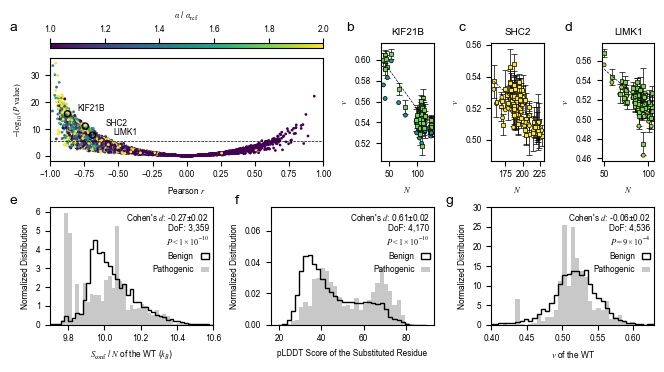

In [61]:
fig = plt.figure(figsize=(6.6,3.7))
ax1 = plt.subplot2grid( (2,6), (0,0), rowspan=1, colspan=3 )
ax2 = plt.subplot2grid( (2,6), (0,3), rowspan=1, colspan=1 )
ax3 = plt.subplot2grid( (2,6), (0,4), rowspan=1, colspan=1 )
ax4 = plt.subplot2grid( (2,6), (0,5), rowspan=1, colspan=1 )
ax5 = plt.subplot2grid( (2,6), (1,0), rowspan=1, colspan=2 )
ax6 = plt.subplot2grid( (2,6), (1,2), rowspan=1, colspan=2 )
ax7 = plt.subplot2grid( (2,6), (1,4), rowspan=1, colspan=2 )
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

families = pd.read_pickle('idr_orthologs/data/conf_buffering_families.pkl')
p_values_threshold = 0.05/families.shape[0]

print(f'Families with p-value < {p_values_threshold:.3g} and alpha ratio > 1.5'.format(p_values_threshold))
print(families.query(f'nu_pcorr_p<3.282e-6 and nu_alpha_ratio>1.5').shape,families.shape)

df_conf_buffering = pd.read_csv('md_simulations/data/conf_buffering/conf_buffering_md_data.csv',index_col=0)
print('mean error on nu',df_conf_buffering.nu_err.mean())

nu_benign = df_variants.query('significance == "benign"').nu_sim
SPR_benign = df_variants.query('significance == "benign"').SPR_sim
pLDDT_benign = df_variants.query('significance == "benign"').pLDDT
nu_pathogenic = df_variants.query('significance == "pathogenic"').nu_sim
SPR_pathogenic = df_variants.query('significance == "pathogenic"').SPR_sim
pLDDT_pathogenic = df_variants.query('significance == "pathogenic"').pLDDT

print(nu_benign.size,nu_pathogenic.size)

bin_width = .02
bins = np.arange(9.4, 11.5,bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(SPR_pathogenic,bins=bins,density=True)[0]
ax5.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax5.hist(SPR_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

dof = f'DoF: {calc_dof(SPR_pathogenic, SPR_benign):,.0f}'
statistic, p_less = stats.brunnermunzel(SPR_pathogenic, SPR_benign, alternative='less')
cohensd, cohensd_se = bootstrapped_cohens_d(SPR_pathogenic, SPR_benign, 100000)
cohensd_label = f"Cohen's $d$: {cohensd:.2f}±{cohensd_se:.2f}"
p_less_label = f'$P={format_scientific(p_less)}$' if p_less >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax5.legend(handlelength=1,frameon=False,
                 title=cohensd_label+'\n'+dof+'\n'+p_less_label,
                 markerfirst=False,alignment='right',borderpad=0)
leg.get_title().set_ha('right') 
#########

bin_width = 2
bins = np.arange(19.5, 90,bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(pLDDT_pathogenic,bins=bins,density=True)[0]
ax6.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax6.hist(pLDDT_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

dof = f'DoF: {calc_dof(pLDDT_pathogenic,pLDDT_benign):,.0f}'
statistic, p_greater = stats.brunnermunzel(pLDDT_pathogenic, pLDDT_benign, alternative='greater')
cohensd, cohensd_se = bootstrapped_cohens_d(pLDDT_pathogenic, pLDDT_benign, 100000)
cohensd_label = f"Cohen's $d$: {cohensd:.2f}±{cohensd_se:.2f}"
p_greater_label = f'$P={format_scientific(p_greater)}$' if p_greater >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax6.legend(handlelength=1,frameon=False,
                 title=cohensd_label+'\n'+dof+'\n'+p_greater_label,
                 markerfirst=False,alignment='right',borderpad=0)
leg.get_title().set_ha('right') 

############

bin_width = .006
bins = np.arange(0.05, .74, bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(nu_pathogenic,bins=bins,density=True)[0]
ax7.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax7.hist(nu_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

dof = f'DoF: {calc_dof(nu_pathogenic, nu_benign):,.0f}'
statistic, p_less = stats.brunnermunzel(nu_pathogenic, nu_benign, alternative='less')
cohensd, cohensd_se = bootstrapped_cohens_d(nu_pathogenic, nu_benign, 100000)
cohensd_label = f"Cohen's $d$: {cohensd:.2f}±{cohensd_se:.2f}"
p_less_label = f'$P={format_scientific(p_less)}$' if p_less >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax7.legend(handlelength=1,frameon=False,loc='upper right',
                 title=cohensd_label+'\n'+dof+'\n'+p_less_label,
                 markerfirst=False,alignment='right',borderpad=0)
leg.get_title().set_ha('right') 

#########

im = ax1.scatter(families.nu_pcorr, 
            -np.log10(families.nu_pcorr_p), marker='o', s=4, 
         lw=0, c=families.nu_alpha_ratio,vmin=1,vmax=2)

ax1.axhline(-np.log10(p_values_threshold),ls='--',color='k',lw=.5)

divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="{:.1f}%".format(5), pad=.1)
fig.add_axes(cax)
cb = fig.colorbar(im, cax=cax, orientation='horizontal',
                label=r'$\alpha$ / $\alpha_\mathrm{ref}$')
cax.xaxis.set_label_position('top'); cax.xaxis.set_ticks_position('top')

ax1.set_xlabel('Pearson $r$')
ax1.set_ylabel("$-\log_{10}(P\;\mathrm{value})$")

############

for name,ax,title in zip(['O75037_811_918','P98077_303_484','P53667_251_339'],
                   [ax2,ax3,ax4],['KIF21B','SHC2','LIMK1']):
    
    print(title,'alpha ratio',families.loc[name].nu_alpha_ratio)

    example = families.loc[name]  
    # Plotting correlation
    ax.scatter(example.N[np.argsort(example.N)], example.nu[np.argsort(example.N)], 
            s=8, c=[example.nu_alpha_ratio]*example.N.size, vmin=1, vmax=2, edgecolors='k', lw=.5)
    
    md_data = df_conf_buffering[df_conf_buffering.human==name]
    alpha, _ = np.polyfit(md_data.N,md_data.nu, 1)
    ax.scatter(md_data.N,md_data.nu,marker='s',
            s=8, c=[alpha/example.nu_alpha_ref]*example.N.size, vmin=1, vmax=2, edgecolors='k', lw=.5)
    ax.errorbar(md_data.N,md_data.nu,yerr=md_data.nu_err,ms=0,lw=0,zorder=0,
             elinewidth=.5,capsize=2,capthick=.5,color='k')
  
    N = np.array([md_data.N.min(), md_data.N.max()])
    slope, intersect = np.polyfit(md_data.N, md_data.nu, 1)
    ax.plot(N, N*slope+intersect, c='k', ls='--', label=fr'$r={example.nu_pcorr:.2f}$', lw=.5)
    
    ax1.scatter(example.nu_pcorr, 
            -np.log10(example.nu_pcorr_p), marker='o', s=20, fc='None',
         lw=1, ec='k')
    
    if title == 'KIF21B':
        ax1.annotate(title,xy=(example.nu_pcorr+.07,-np.log10(example.nu_pcorr_p)+1))
    else:
        ax1.annotate(title,xy=(example.nu_pcorr+.15,-np.log10(example.nu_pcorr_p)))
        
    ax.set_title(title)
    ax.set_ylabel('$\\nu$')
    ax.set_xlabel('$N$')
    
############

ax1.set_xlim(-1,1)
ax5.set_xlim(9.7,10.6)
ax6.set_ylim(0,.075)
ax7.set_xlim(.4,.63)
ax7.set_ylim(0,30)

ax5.set_xlabel(r'$S_\mathrm{conf}$ / $N$ of the WT ($k_B$)')
ax6.set_xlabel(r'pLDDT Score of the Substituted Residue')
ax7.set_xlabel('$\\nu$ of the WT')
ax5.set_ylabel('Normalized Distribution')
ax6.set_ylabel('Normalized Distribution')
ax7.set_ylabel('Normalized Distribution')

fig.text(0.01, .92, 'a', fontsize=10)
fig.text(0.52, .92, 'b', fontsize=10)
fig.text(0.69, .92, 'c', fontsize=10)
fig.text(0.85, .92, 'd', fontsize=10)
fig.text(0.01, .45, 'e', fontsize=10)
fig.text(0.35, .45, 'f', fontsize=10)
fig.text(0.67, .45, 'g', fontsize=10)

plt.tight_layout()
fig.savefig('figs/fig5.pdf',dpi=300)

#### Analysis of frameshift variants in C-terminal IDRs identified by Mensah et al. (DOI: 10.1038/s41586-022-05682-1)
The list of variants with ClinVar significance annotations were obtained from https://zenodo.org/record/7311150/files/MasterTable_wNMD_wVariantDisease_wRK_WHidrophobic_wNLS_wTransmembrane_220608_Full.csv.zip

In [33]:
url = """https://zenodo.org/record/7311150/files/MasterTable_wNMD_wVariantDisease_
wRK_WHidrophobic_wNLS_wTransmembrane_220608_Full.csv.zip""".replace('\n','')

#### Load table and select IDRs with WT and variant sequence lengths $\geq30$

In [34]:
df_frameshift = pd.read_csv(url, low_memory=False)
df_frameshift = df_frameshift.query('SeqType == "Frameshift"')
df_frameshift = df_frameshift.rename({'IDRseq':'fasta', 'TrueIDRstart':'first',
                      'WTIDRseq':'fasta_WT', 'WTFullLength':'N_FL'},axis=1)
df_frameshift['N_WT'] = df_frameshift.fasta_WT.apply(len)
df_frameshift['N'] = df_frameshift.fasta.apply(len)
df_frameshift = df_frameshift.query('N >= 30 and N_WT >= 30')
df_frameshift['last'] = df_frameshift['N_FL']

#### Calculate Flory scaling exponents for WT and variants using the SVR model

In [35]:
if not os.path.isfile('clinvar_fmug_cdcode/data/frameshift_variants.csv.gz'):
    for ndx in df_frameshift.index:
        calc_seq_prop(df_frameshift,r,ndx,nu_model,SPR_model)
    df_frameshift['Delta_nu'] = df_frameshift['nu'] - df_frameshift['nu_WT']
    df_frameshift['Delta_SPR'] = df_frameshift['SPR'] - df_frameshift['SPR_WT']
    df_frameshift.to_csv('clinvar_fmug_cdcode/data/frameshift_variants.csv.gz')
else:
    df_frameshift = pd.read_csv('clinvar_fmug_cdcode/data/frameshift_variants.csv.gz',index_col=0)

#### Find IDRs in pathogenic variants in IDRs with low conformational entropy per residue

In [36]:
df_variants['is_cys'] = df_variants.index.map(lambda x :
                1 if ('_C' in x or x[-1]=='C') else 0)

df_idrome_domain = pd.read_csv('IDRome_DB_Domains.csv',index_col=0)
indices = df_variants.query('significance == "pathogenic" and SPR <= 9.8').WT.unique()
df_var_domains = df_idrome_domain.loc[indices,['Descriptions','fdomain','nu']]
df_var_domains['number_C_variants'] = df_variants[df_variants.WT.isin(df_var_domains.index)][
                        ['WT','is_cys']].groupby('WT').sum()
df_idrome.loc[df_var_domains.index,'protein_name']

seq_name
P02462_1_1436                     Collagen alpha-1(IV) chain
P08572_1_1484                     Collagen alpha-2(IV) chain
P09651_187_372    Heterogeneous nuclear ribonucleoprotein A1
P13645_1_151                 Keratin, type I cytoskeletal 10
P29400_1_1456                     Collagen alpha-5(IV) chain
P35527_1_157                  Keratin, type I cytoskeletal 9
P35637_1_285                         RNA-binding protein FUS
P53420_1_1456                     Collagen alpha-4(IV) chain
Name: protein_name, dtype: object

#### Find IDRs with pathogenic variants in folded domains
The N-terminal domain of Neurogenic locus notch homolog protein 3 has 110 pathogenic substitutions to or from cystein residues which may be involved in EGF-like domains. With a scaling exponent of 0.434, this IDR alone significantly increases the significance of the association between pathogenicity and compaction. 

In [37]:
df_variants['is_cys'] = df_variants.index.map(lambda x :
                1 if ('_C' in x or x[-1]=='C') else 0)

df_idrome_domain = pd.read_csv('IDRome_DB_Domains.csv',index_col=0)
indices = df_variants.query('significance == "pathogenic" and fdomain > 0 and nu <= 0.45').WT.unique()
df_var_domains = df_idrome_domain.loc[indices,['Descriptions','fdomain','nu']]
df_var_domains['number_C_variants'] = df_variants[df_variants.WT.isin(df_var_domains.index)][
                        ['WT','is_cys']].groupby('WT').sum()
df_var_domains['number_variants'] = df_variants[df_variants.WT.isin(df_var_domains.index)][
                        ['WT','is_cys']].groupby('WT').count()
df_var_domains.sort_values('fdomain')

,Descriptions,fdomain,nu,number_C_variants,number_variants
seq_name,,,,,
P51610_397_1822,Fibronectin type-III 2,0.017532,0.534,1,16
Q9UM47_1_1399,EGF-like 34,0.027162,0.434,110,148
Q9UL68_1_1057,Zinc finger,0.040681,0.255,1,12
Q8IZC6_227_1666,Collagen-like 16,0.040972,0.514,2,32
Q9NQX1_1_316,Zinc finger,0.066456,0.457,2,4
P42768_307_502,WH2,0.086735,0.482,0,9
Q13402_787_1000,IQ 5,0.093458,0.152,0,4
P55895_341_527,Zinc finger,0.363636,0.268,1,8


#### How many pathogenic substitutions involve cysteins?
Out of 5,815 pathogenic variants, 691 (11.9%) are substitutions to or from cystein residues. Excluding IDRs containing domain annotations, the fraction of pathogenic variants involving cysteins decreases to 6.3%.

In [38]:
indices = df_variants.query('significance == "pathogenic"').WT.unique()
pathogenic_variants = np.array(clinvar_info.loc[indices].variants.sum())
print(pathogenic_variants.size)
print(np.sum(['C' in i for i in pathogenic_variants]))
print(np.sum(['C' in i for i in pathogenic_variants])/pathogenic_variants.size*100)

5815
691
11.883061049011177


In [39]:
indices = df_variants.query('significance == "pathogenic" and fdomain == 0').WT.unique()
pathogenic_variants = np.array(clinvar_info.loc[indices].variants.sum())
print(pathogenic_variants.size)
print(np.sum(['C' in i for i in pathogenic_variants]))
print(np.sum(['C' in i for i in pathogenic_variants])/pathogenic_variants.size*100)

3767
238
6.318024953543934


#### Extdended Data Fig. 9

/var/folders/y_/2x90pfvj0138gctc5qx9196m0000gn/T/ipykernel_13533/2294929661.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'nu_intervals'] = intervals.values
/var/folders/y_/2x90pfvj0138gctc5qx9196m0000gn/T/ipykernel_13533/2294929661.py:215: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:,'nu_intervals'] = intervals.values


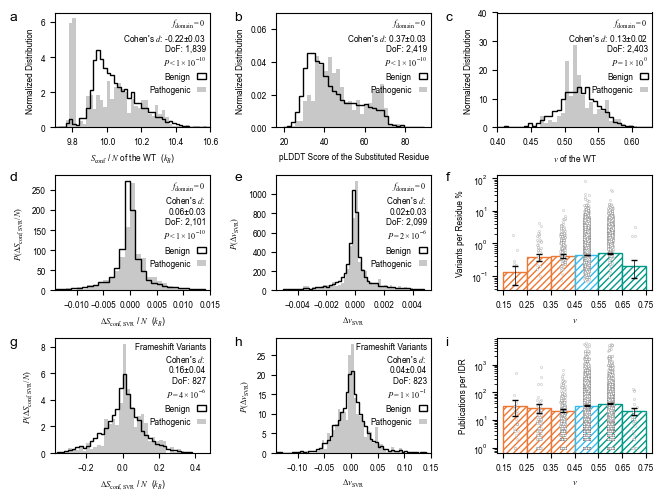

In [63]:
fig, ((ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)) = plt.subplots(3, 3, 
                                                sharex=False, sharey=False, figsize=(6.6,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

nu_benign = df_variants.query('significance == "benign" and fdomain == 0').nu_sim
SPR_benign = df_variants.query('significance == "benign" and fdomain == 0').SPR_sim
pLDDT_benign = df_variants.query('significance == "benign" and fdomain == 0').pLDDT
nu_pathogenic = df_variants.query('significance == "pathogenic" and fdomain == 0').nu_sim
SPR_pathogenic = df_variants.query('significance == "pathogenic" and fdomain == 0').SPR_sim
pLDDT_pathogenic = df_variants.query('significance == "pathogenic" and fdomain == 0').pLDDT

bin_width = .02
bins = np.arange(9.4, 11.5,bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(SPR_pathogenic,bins=bins,density=True)[0]
ax1.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax1.hist(SPR_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

statistic, p_less = stats.brunnermunzel(SPR_pathogenic, SPR_benign, alternative='less')
dof = f'DoF: {calc_dof(SPR_pathogenic, SPR_benign):,.0f}'
cohensd, cohensd_se = bootstrapped_cohens_d(SPR_pathogenic, SPR_benign, 100000)
cohensd_label = f"Cohen's $d$: {cohensd:.2f}±{cohensd_se:.2f}"
p_less_label = f'$P={format_scientific(p_less)}$' if p_less >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax1.legend(handlelength=1,frameon=False,
                 title='$f_\mathrm{domain}=0$\n'+cohensd_label+'\n'+dof+'\n'+p_less_label,
                 markerfirst=False,alignment='right',borderpad=0)
leg.get_title().set_ha('right') 

#########

bin_width = 2
bins = np.arange(19.5, 90,bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(pLDDT_pathogenic,bins=bins,density=True)[0]
ax2.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax2.hist(pLDDT_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

dof = f'\nDoF: {calc_dof(pLDDT_pathogenic, pLDDT_benign):,.0f}'
statistic, p_greater = stats.brunnermunzel(pLDDT_pathogenic, pLDDT_benign, alternative='greater')
cohensd, cohensd_se = bootstrapped_cohens_d(pLDDT_pathogenic, pLDDT_benign, 100000)
cohensd_label = f"Cohen's $d$: {cohensd:.2f}±{cohensd_se:.2f}"
p_greater_label = f'$P={format_scientific(p_greater)}$' if p_greater >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax2.legend(handlelength=1,frameon=False,
                 title='$f_\mathrm{domain}=0$\n'+cohensd_label+dof+'\n'+p_greater_label,
                 markerfirst=False,alignment='right',borderpad=0)
leg.get_title().set_ha('right') 

############

bin_width = .006
bins = np.arange(0.05, .74, bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(nu_pathogenic,bins=bins,density=True)[0]
ax3.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax3.hist(nu_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

dof = f'\nDoF: {calc_dof(nu_pathogenic, nu_benign):,.0f}'
statistic, p_less = stats.brunnermunzel(nu_pathogenic, nu_benign, alternative='less')
cohensd, cohensd_se = bootstrapped_cohens_d(nu_pathogenic, nu_benign, 100000)
cohensd_label = f"Cohen's $d$: {cohensd:.2f}±{cohensd_se:.2f}"
p_less_label = f'$P={format_scientific(p_less)}$' if p_less >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax3.legend(handlelength=1,frameon=False,
                 title='$f_\mathrm{domain}=0$\n'+cohensd_label+dof+'\n'+p_less_label,
                 markerfirst=False,alignment='right',borderpad=0,loc='upper right')
leg.get_title().set_ha('right') 

#########

nu_benign = df_variants.query('significance == "benign" and fdomain == 0').Delta_nu
SPR_benign = df_variants.query('significance == "benign" and fdomain == 0').Delta_SPR
nu_pathogenic = df_variants.query('significance == "pathogenic" and fdomain == 0').Delta_nu
SPR_pathogenic = df_variants.query('significance == "pathogenic" and fdomain == 0').Delta_SPR

#########

bin_width = .001
bins = np.arange(-.015, .015,bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(SPR_pathogenic,bins=bins,density=True)[0]
ax4.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax4.hist(SPR_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

statistic, p_greater = stats.brunnermunzel(SPR_pathogenic, SPR_benign, alternative='greater')
dof = f'\nDoF: {calc_dof(SPR_pathogenic, SPR_benign):,.0f}'
cohensd, cohensd_se = bootstrapped_cohens_d(SPR_pathogenic, SPR_benign, 100000)
cohensd_label = f"\nCohen's $d$:\n{cohensd:.2f}±{cohensd_se:.2f}"
p_greater_label = f'$P={format_scientific(p_greater)}$' if p_greater >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax4.legend(handlelength=1,frameon=False,
           title='$f_\mathrm{domain}=0$'+cohensd_label+dof+'\n'+p_greater_label,
           markerfirst=False,alignment='right',borderpad=0,loc='upper right')
leg.get_title().set_ha('right') 
ax4.set_xlim(-.014,.015)

############

bin_width = .0002
bins = np.arange(-.005, .005, bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(nu_pathogenic,bins=bins,density=True)[0]
ax5.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax5.hist(nu_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

statistic, p_greater = stats.brunnermunzel(nu_pathogenic, nu_benign, alternative='greater')
dof = f'\nDoF: {calc_dof(nu_pathogenic, nu_benign):,.0f}'
cohensd, cohensd_se = bootstrapped_cohens_d(nu_pathogenic, nu_benign, 100000)
cohensd_label = f"\nCohen's $d$:\n{cohensd:.2f}±{cohensd_se:.2f}"
p_greater_label = f'$P={format_scientific(p_greater)}$' if p_greater >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax5.legend(handlelength=1,frameon=False,markerfirst=False,alignment='right',borderpad=0,
           title='$f_\mathrm{domain}=0$'+cohensd_label+dof+'\n'+p_greater_label)
leg.get_title().set_ha('right') 

#########

nu_benign = df_frameshift.query('Pathogenic == False').Delta_nu
SPR_benign = df_frameshift.query('Pathogenic == False').Delta_SPR
nu_pathogenic = df_frameshift.query('Pathogenic == True').Delta_nu
SPR_pathogenic = df_frameshift.query('Pathogenic == True').Delta_SPR

#########

bin_width = .02
bins = np.arange(-.4, .4,bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(SPR_pathogenic,bins=bins,density=True)[0]
ax7.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax7.hist(SPR_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

statistic, p_greater = stats.brunnermunzel(SPR_pathogenic, SPR_benign, alternative='greater')
dof = f'\nDoF: {calc_dof(SPR_pathogenic, SPR_benign):,.0f}'
cohensd, cohensd_se = bootstrapped_cohens_d(SPR_pathogenic, SPR_benign, 100000)
cohensd_label = f"\nCohen's $d$:\n{cohensd:.2f}±{cohensd_se:.2f}"
p_greater_label = f'$P={format_scientific(p_greater)}$' if p_greater >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax7.legend(handlelength=1,frameon=False,markerfirst=False,alignment='right',borderpad=0,loc='upper right',
           title='Frameshift Variants'+cohensd_label+dof+'\n'+p_greater_label)
leg.get_title().set_ha('right') 
ax7.set_xlim(-.37,.48)

#########

bin_width = .005
bins = np.arange(-.15, .15, bin_width)
x = bins[:-1]+bin_width/2.

h = np.histogram(nu_pathogenic,bins=bins,density=True)[0]
ax8.bar(x,h,alpha=.8,width=bin_width,color=pt_colors['grey'],
           label='Pathogenic')

ax8.hist(nu_benign,bins,density=True,histtype='step',
         color='k',zorder=1,label='Benign')

statistic, p_greater = stats.brunnermunzel(nu_pathogenic, nu_benign, alternative='greater')
dof = f'\nDoF: {calc_dof(nu_pathogenic, nu_benign):,.0f}'
cohensd, cohensd_se = bootstrapped_cohens_d(nu_pathogenic, nu_benign, 100000)
cohensd_label = f"\nCohen's $d$:\n{cohensd:.2f}±{cohensd_se:.2f}"
p_greater_label = f'$P={format_scientific(p_greater)}$' if p_greater >= 1e-10 else '$P<1\\times10^{-10}$'
leg = ax8.legend(handlelength=1,frameon=False,markerfirst=False,alignment='right',borderpad=0,loc='upper right',
           title='Frameshift Variants'+cohensd_label+dof+'\n'+p_greater_label)
leg.get_title().set_ha('right') 
ax8.set_xlim(-.14,.15)

############

intervals = pd.cut(df_idrome['nu'], np.arange(.15, .8, .1))
df_idrome['n_variants_per_res'] = df_idrome['n_variants'] / df_idrome['N'] * 100
df = df_idrome[['nu','n_variants_per_res']]
df.loc[:,'nu_intervals'] = intervals.values

sns.stripplot(ax=ax6,data=df,x='nu_intervals',y='n_variants_per_res',
              color='w',jitter=True,
              size=1.5,dodge=True,edgecolor='k',linewidth=.1)

mean_std = df_idrome['n_variants_per_res'].groupby(intervals).agg(['mean',se,'count'])
mean_std['mean'].plot(rot=0, ax=ax6, kind='bar', hatch='/////',color='w',
                      edgecolor=[pt_colors['orange']]*3+[pt_colors['cyan']]*1+[pt_colors['teal']]*2,width=1)
mean_std['mean'].plot(rot=0, ax=ax6, kind='bar', yerr=mean_std['SE'],color='None',
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      edgecolor='None',width=1,zorder=10)

ax6.set_xticks(np.arange(mean_std.index.size+1)-.5)
ax6.set_xticklabels([.15]+[i.right for i in mean_std.index])

ax6.set_ylabel('Variants per Residue %')
ax6.set_xlabel(r'$\nu$')

ax6.set_yscale('log')

############

intervals = pd.cut(df_idrome['nu'], np.arange(.15, .8, .1))
df = df_idrome[['nu','n_pubs']]
df.loc[:,'nu_intervals'] = intervals.values

sns.stripplot(ax=ax9,data=df,x='nu_intervals',y='n_pubs',
              color='w',jitter=True,
              size=1.5,dodge=True,edgecolor='k',linewidth=.1)

mean_std = df_idrome['n_pubs'].groupby(intervals).agg(['mean',se,'count'])
mean_std['mean'].plot(rot=0, ax=ax9, kind='bar', hatch='/////',color='w',
                      edgecolor=[pt_colors['orange']]*3+[pt_colors['cyan']]*1+[pt_colors['teal']]*2,width=1)
mean_std['mean'].plot(rot=0, ax=ax9, kind='bar', yerr=mean_std['SE'],color='None',
                      error_kw=dict(ecolor='black',elinewidth=0.5,capsize=2),
                      edgecolor='None',width=1,zorder=10)

ax9.set_xticks(np.arange(mean_std.index.size+1)-.5)
ax9.set_xticklabels([.15]+[i.right for i in mean_std.index])

ax9.set_ylabel(r'Publications per IDR')
ax9.set_xlabel(r'$\nu$')

ax9.set_yscale('log')

##########

ax3.set_xlim(.4,.63)
ax1.set_xlim(9.7,10.6)

ax1.set_xlabel(r'$S_\mathrm{conf}$ / $N$ of the WT  ($k_B$)')
ax2.set_xlabel(r'pLDDT Score of the Substituted Residue')
ax3.set_xlabel('$\\nu$ of the WT')
ax1.set_ylabel('Normalized Distribution')
ax2.set_ylabel('Normalized Distribution')
ax3.set_ylabel('Normalized Distribution')

ax5.set_xlabel('$\Delta \\nu_{\mathrm{SVR}}$')
ax4.set_xlabel(r'$\Delta  S_{\mathrm{conf},\mathrm{SVR}}$ / $N$  ($k_B$)')
ax5.set_ylabel('$P(\Delta \\nu_{\mathrm{SVR}})$')
ax4.set_ylabel('$P(\Delta  S_{\mathrm{conf},\mathrm{SVR}} / N)$')

ax8.set_xlabel('$\Delta \\nu_{\mathrm{SVR}}$')
ax7.set_xlabel(r'$\Delta  S_{\mathrm{conf},\mathrm{SVR}}$ / $N$  ($k_B$)')
ax8.set_ylabel('$P(\Delta \\nu_{\mathrm{SVR}})$')
ax7.set_ylabel('$P(\Delta  S_{\mathrm{conf},\mathrm{SVR}} / N)$')

fig.text(0.01, .96, 'a', fontsize=10)
fig.text(0.35, .96, 'b', fontsize=10)
fig.text(0.67, .96, 'c', fontsize=10)
fig.text(0.01, .64, 'd', fontsize=10)
fig.text(0.35, .64, 'e', fontsize=10)
fig.text(0.67, .64, 'f', fontsize=10)
fig.text(0.01, .31, 'g', fontsize=10)
fig.text(0.35, .31, 'h', fontsize=10)
fig.text(0.67, .31, 'i', fontsize=10)

ax2.set_ylim(0,.07)
ax3.set_ylim(0,40)

plt.tight_layout()
fig.savefig('figs/ED_fig9.jpg',dpi=600)

#### Print statistics on analysed missense variants

In [19]:
print('Number of variants',df_variants.shape[0])
print('Number of pathogenic variants',df_variants.query('significance == "pathogenic"').shape[0])
print('Number of benign variants',df_variants.query('significance == "benign"').shape[0])
print('Number of IDRs',df_variants.WT.unique().size)
print('Number of proteins',df_idrome.loc[df_variants.WT].UniProt_ID.unique().size)

Number of variants 18445
Number of pathogenic variants 2888
Number of benign variants 15557
Number of IDRs 6217
Number of proteins 4292


#### Print statistics on analysed frameshift variants

In [20]:
print('Number of variants',df_frameshift.shape[0])
print('Number of pathogenic variants',df_frameshift.query('Pathogenic == True').shape[0])
print('Number of benign variants',df_frameshift.query('Pathogenic == False').shape[0])
print('Number of IDRs',df_frameshift.fasta_WT.unique().size)
print('Number of proteins',df_frameshift.Gene.unique().size)

Number of variants 5676
Number of pathogenic variants 637
Number of benign variants 5039
Number of IDRs 2273
Number of proteins 2280


#### Find IDRs with low $S_{conf}/N$, $f_\text{domain}=0$, and pathogenic variants 

In [21]:
bool_not_C = [False if ('_C' in x or x[-1]=='C') else True for x in df_variants.index]

df_idrome.loc[df_variants[bool_not_C].query(
    'significance == "pathogenic" and SPR_sim < 9.8 and fdomain == 0').WT,'protein_name'].unique()

array(['Homeobox protein SIX3', 'Collagen alpha-2(IV) chain',
       'Keratin, type I cytoskeletal 16',
       'Heterogeneous nuclear ribonucleoprotein A1',
       'Keratin, type I cytoskeletal 10',
       'Keratin, type II cytoskeletal 5', 'Elastin',
       'Collagen alpha-5(IV) chain', 'Keratin, type I cytoskeletal 9',
       'RNA-binding protein FUS', 'Collagen alpha-4(IV) chain',
       'Collagen alpha-3(IV) chain', 'Keratin, type I cytoskeletal 12',
       'Unconventional myosin-XV', 'Collagen alpha-1(XVII) chain'],
      dtype=object)

#### Find IDRs for hnRNPA1, hnRNPA2, and FUS

In [22]:
df_idrome[df_idrome.UniProt_ID.isin(['P22626','P09651','P35637'])][['protein_name','nu','SPR']]

,protein_name,nu,SPR
seq_name,,,
P09651_187_372,Heterogeneous nuclear ribonucleoprotein A1,0.453,9.626051
P22626_194_353,Heterogeneous nuclear ribonucleoproteins A2/B1,0.449,9.608441
P35637_369_526,RNA-binding protein FUS,0.497,9.788539
P35637_1_285,RNA-binding protein FUS,0.465,9.762312


#### Find IDRs for nucleophosmin, nuclear speckle protein snRNP subunit U1-70k, DAXX, ATRX, and CTR9

In [23]:
df_idrome[df_idrome.UniProt_ID.isin(['P06748','P08621','Q9UER7','P46100','Q6PD62'])][['protein_name','nu','SPR']]

,protein_name,nu,SPR
seq_name,,,
P06748_122_247,Nucleophosmin,0.418,10.262282
P08621_202_437,U1 small nuclear ribonucleoprotein 70 kDa,0.311,9.957260
P46100_2419_2492,Transcriptional regulator ATRX,0.536,10.170300
P46100_2184_2319,Transcriptional regulator ATRX,0.525,10.155034
P46100_1_176,Transcriptional regulator ATRX,0.520,10.104786
P46100_1855_2006,Transcriptional regulator ATRX,0.523,10.016912
P46100_289_1546,Transcriptional regulator ATRX,0.482,9.962265
Q6PD62_879_1173,RNA polymerase-associated protein CTR9 homolog,0.450,9.999649
Q9UER7_1_61,Death domain-associated protein 6,0.508,10.156153
